# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [5]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [6]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[ 0.01568196  0.23524951  0.00807771 -0.32637235] 1 1.0 False {}
state, action, reward, done, info
[ 0.02038695  0.04001349  0.00155026 -0.03115305] 0 1.0 False {}
state, action, reward, done, info
[ 0.02118722 -0.15513066  0.0009272   0.2620186 ] 0 1.0 False {}
state, action, reward, done, info
[ 0.01808461  0.03997805  0.00616757 -0.03037174] 1 1.0 False {}
state, action, reward, done, info
[ 0.01888417 -0.15523181  0.00556014  0.26425073] 0 1.0 False {}
state, action, reward, done, info
[ 0.01577953 -0.35043268  0.01084515  0.55868218] 0 1.0 False {}
state, action, reward, done, info
[ 0.00877088 -0.54570517  0.0220188   0.8547621 ] 0 1.0 False {}
state, action, reward, done, info
[-0.00214322 -0.74112017  0.03911404  1.15428656] 0 1.0 False {}
state, action, reward, done, info
[-0.01696563 -0.93672979  0.06219977  1.45897316] 0 1.0 False {}
state, action, reward, done, info
[-0.03570022 -0.74242342  0.09137923  1.18635217] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.4589731594162392 -0.9367297874770026


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
# Data of the model
def model_input(state_size):
    # Current states and actions for calculating Qs
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # nextQs calculated using next_states and dones/end-of-episodes
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs')
    
    # returning the given data to the model
    return states, actions, nextQs

In [9]:
# Generator: Generating the actions
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [10]:
def model_loss(states, actions, nextQs, # model input data for targetQs
               action_size, hidden_size): # model init for Qs
    # Calculating Qs total rewards
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    
    # Masking the actions logits
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # Calculating the loss: logits/predictions vs labels
    q_loss = tf.reduce_mean(tf.square(Qs - nextQs))
    
    return actions_logits, q_loss

In [11]:
def model_opt(q_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)

    return q_opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.nextQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt = model_opt(q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
# from collections import deque

# class Memory():    
#     def __init__(self, max_size = 1000):
#         self.buffer = deque(maxlen=max_size)
    
#     def add(self, experience):
#         self.buffer.append(experience)
            
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), 
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [39]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200000000000000000 # max steps in an episode
# gamma = 0.99                 # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
# memory_size = 100000           # memory capacity
# batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [40]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# # Init the memory
# memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [41]:
# # Initialize the simulation
# env.reset()

# # Take one random step to get the pole and cart moving
# prev_action = env.action_space.sample() # At-1
# state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# # Batch memory which is not a memory but a buffer including a batch
# batch = []

# # Make a bunch of random actions and store the experiences
# for _ in range(batch_size):
    
#     # Make a random action
#     action = env.action_space.sample()# At
#     next_state, _, done, _ = env.step(action) #St+1

#     # End of the episodes which defines the goal of the episode/mission
#     if done is True:
#         # Add experience to memory
#         #memory.add((prev_action, state, action, next_state, done))
#         batch.append([prev_action, state, action, next_state, done])
        
#         # Start new episode
#         env.reset()
        
#         # Take one random step to get the pole and cart moving
#         prev_action = env.action_space.sample()
#         state, _, done, _ = env.step(prev_action)
#     else:
#         # Add experience to memory
#         #memory.add((prev_action, state, action, next_state, done))
#         batch.append([prev_action, state, action, next_state, done])
        
#         # Prepare for the next round
#         prev_action = action
#         state = next_state

In [42]:
# len(batch), len(batch[0]), batch[0][0], batch[0][1].shape, batch[0][2]

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [43]:
# # Training episodes/epochs
# for ep in range(10):
# #     print(ep)

#     # Batch memory which is not a memory but a buffer including a batch
#     # Replacing the memory
#     # creating a bigger batch, i.e. reseting input data batch every 3 episodes
#     if np.mod(ep, 3)==0:
#         print('reset batch')
#         batch = []

In [44]:
# Save and restore/load the trained model outside the training session/graph
saver = tf.train.Saver()

# Total rewards and losses list for plotting outside the training session
rewards_list = [] # accuracy
q_loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
           
    # Explore/exploit env step for producing an action for all the episodes/epochs
    step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        #print(ep)
        
        # Initialize the env in the beginning of every episode
        env.reset()
        # Prev action, state and done
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample() # At-1
        state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

        # Replacing batch size
        # Batch memory which is not a memory but a buffer including a batch
        # Replacing the memory
        # creating a bigger batch, i.e. reseting input data batch every 3 episodes
        if np.mod(ep, 3) == 0:
            batch = []
            
        # Env/agent steps/batches/minibatches for every epoch/episode
        total_reward = 0
        q_loss = 0
                
        ########################## Creating the input/output data batch ###############################################
        t = 0 # Used to make while a for loop
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                                
                # Add experience to memory
                #memory.add((prev_action, state, action, next_state, done))
                batch.append([prev_action, state, action, next_state, done])
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                #memory.add((prev_action, state, action, next_state, done))
                batch.append([prev_action, state, action, next_state, done])

                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
        ########################## Training the model using the current batch ###############################################
        # Sample mini-batch from memory
        #batch = memory.sample(batch_size)
        prev_actions = np.array([each[0] for each in batch])
        states = np.array([each[1] for each in batch])
        actions = np.array([each[2] for each in batch])
        next_states = np.array([each[3] for each in batch])
        dones = np.array([each[4] for each in batch])

        # Calculating nextQs and setting them to 0 for states where episode ends/fails
        feed_dict={model.states: next_states}
        next_actions_logits = sess.run(model.actions_logits, feed_dict)            

        # Masking the nextQs using dones/end-of-episodes which defines the goal/task in this episode
        next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
        nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
        nextQs = np.max(nextQs_masked, axis=1)

        # Updating the model: Calculating Qs using states and actions and Qt = rs/qs + (gamma * nextQs) 
        feed_dict = {model.states: states, 
                     model.actions: actions, 
                     model.nextQs: nextQs}
        q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
        
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Training q_loss: {:.4f}'.format(q_loss),
              'Explore P: {:.4f}'.format(explore_p))
        print('-------------------------------------------------------------------------------')

        # Save the total rewards and losses for plotting outside traininig session/graph
        rewards_list.append((ep, total_reward))
        q_loss_list.append((ep, q_loss))

            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 38 Training q_loss: 0.0009 Explore P: 0.9962
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 14 Training q_loss: 0.0043 Explore P: 0.9949
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 30 Training q_loss: 0.0039 Explore P: 0.9919
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 13 Training q_loss: 0.0028 Explore P: 0.9906
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 52 Total reward: 33 Training q_loss: 0.0136 Explore P: 0.8948
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 53 Total reward: 29 Training q_loss: 0.0132 Explore P: 0.8923
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 54 Total reward: 36 Training q_loss: 0.0126 Explore P: 0.8891
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 55 Total reward: 10 Training q_loss: 0.0173 Explore P: 0.8882
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 89 Total reward: 26 Training q_loss: 0.0061 Explore P: 0.8155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 90 Total reward: 29 Training q_loss: 0.0058 Explore P: 0.8132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 91 Total reward: 16 Training q_loss: 0.0053 Explore P: 0.8119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 92 Total reward: 23 Training q_loss: 0.0046 Explore P: 0.8101
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 125 Total reward: 21 Training q_loss: 0.0065 Explore P: 0.7513
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 126 Total reward: 19 Training q_loss: 0.0026 Explore P: 0.7499
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 127 Total reward: 12 Training q_loss: 0.0053 Explore P: 0.7490
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 128 Total reward: 71 Training q_loss: 0.0028 Explore P: 0.7438
-------------------------------------------------------------------------------
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 166 Total reward: 44 Training q_loss: 0.0034 Explore P: 0.6534
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 31 Training q_loss: 0.0030 Explore P: 0.6514
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 168 Total reward: 86 Training q_loss: 0.0027 Explore P: 0.6459
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 169 Total reward: 31 Training q_loss: 0.0034 Explore P: 0.6440
-------------------------------------------------------------------------------
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 206 Total reward: 25 Training q_loss: 0.0026 Explore P: 0.5811
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 207 Total reward: 23 Training q_loss: 0.0034 Explore P: 0.5798
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 208 Total reward: 46 Training q_loss: 0.0025 Explore P: 0.5771
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 36 Training q_loss: 0.0024 Explore P: 0.5751
-------------------------------------------------------------------------------
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 245 Total reward: 77 Training q_loss: 0.0029 Explore P: 0.4695
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 246 Total reward: 84 Training q_loss: 0.0010 Explore P: 0.4656
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 247 Total reward: 107 Training q_loss: 0.0007 Explore P: 0.4608
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 248 Total reward: 80 Training q_loss: 0.0014 Explore P: 0.4572
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 282 Total reward: 86 Training q_loss: 0.0009 Explore P: 0.3405
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 283 Total reward: 60 Training q_loss: 0.0007 Explore P: 0.3385
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 284 Total reward: 53 Training q_loss: 0.0007 Explore P: 0.3368
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 285 Total reward: 106 Training q_loss: 0.0007 Explore P: 0.3333
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 320 Total reward: 71 Training q_loss: 0.1529 Explore P: 0.2584
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 321 Total reward: 28 Training q_loss: 0.0033 Explore P: 0.2577
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 322 Total reward: 81 Training q_loss: 0.1543 Explore P: 0.2557
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 323 Total reward: 22 Training q_loss: 0.1406 Explore P: 0.2552
-------------------------------------------------------------------------------
------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 356 Total reward: 92 Training q_loss: 0.5697 Explore P: 0.1913
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 357 Total reward: 127 Training q_loss: 0.3122 Explore P: 0.1890
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 358 Total reward: 96 Training q_loss: 0.3936 Explore P: 0.1873
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 359 Total reward: 142 Training q_loss: 0.4066 Explore P: 0.1848
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 392 Total reward: 108 Training q_loss: 0.5792 Explore P: 0.1242
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 393 Total reward: 100 Training q_loss: 0.4898 Explore P: 0.1231
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 394 Total reward: 117 Training q_loss: 0.4324 Explore P: 0.1218
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 395 Total reward: 85 Training q_loss: 0.4663 Explore P: 0.1208
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 428 Total reward: 97 Training q_loss: 0.6184 Explore P: 0.0867
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 429 Total reward: 96 Training q_loss: 0.2596 Explore P: 0.0859
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 430 Total reward: 95 Training q_loss: 0.3780 Explore P: 0.0852
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 431 Total reward: 101 Training q_loss: 0.3912 Explore P: 0.0845
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 465 Total reward: 113 Training q_loss: 0.8116 Explore P: 0.0612
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 466 Total reward: 92 Training q_loss: 0.6664 Explore P: 0.0608
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 467 Total reward: 84 Training q_loss: 0.6288 Explore P: 0.0604
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 468 Total reward: 83 Training q_loss: 0.4688 Explore P: 0.0599
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 502 Total reward: 121 Training q_loss: 0.6347 Explore P: 0.0446
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 503 Total reward: 84 Training q_loss: 0.6013 Explore P: 0.0443
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 504 Total reward: 132 Training q_loss: 0.6838 Explore P: 0.0438
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 505 Total reward: 110 Training q_loss: 0.7024 Explore P: 0.0435
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 538 Total reward: 83 Training q_loss: 0.7221 Explore P: 0.0335
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 539 Total reward: 120 Training q_loss: 0.5683 Explore P: 0.0333
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 540 Total reward: 181 Training q_loss: 0.3631 Explore P: 0.0328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 541 Total reward: 103 Training q_loss: 0.5177 Explore P: 0.0326
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 575 Total reward: 115 Training q_loss: 0.5029 Explore P: 0.0259
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 576 Total reward: 87 Training q_loss: 0.5132 Explore P: 0.0257
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 577 Total reward: 122 Training q_loss: 0.6256 Explore P: 0.0255
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 578 Total reward: 138 Training q_loss: 0.6162 Explore P: 0.0253
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 612 Total reward: 100 Training q_loss: 0.7103 Explore P: 0.0204
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 613 Total reward: 92 Training q_loss: 0.6031 Explore P: 0.0203
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 614 Total reward: 128 Training q_loss: 0.6574 Explore P: 0.0202
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 615 Total reward: 110 Training q_loss: 0.8451 Explore P: 0.0201
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 649 Total reward: 114 Training q_loss: 0.6873 Explore P: 0.0168
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 650 Total reward: 121 Training q_loss: 0.6918 Explore P: 0.0167
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 651 Total reward: 92 Training q_loss: 0.5517 Explore P: 0.0167
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 652 Total reward: 113 Training q_loss: 0.4996 Explore P: 0.0166
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 685 Total reward: 116 Training q_loss: 0.5831 Explore P: 0.0145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 686 Total reward: 119 Training q_loss: 0.6114 Explore P: 0.0144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 687 Total reward: 146 Training q_loss: 0.6456 Explore P: 0.0144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 688 Total reward: 119 Training q_loss: 0.6131 Explore P: 0.0143
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 722 Total reward: 93 Training q_loss: 0.4895 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 723 Total reward: 83 Training q_loss: 0.5884 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 724 Total reward: 117 Training q_loss: 0.5828 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 725 Total reward: 119 Training q_loss: 0.6715 Explore P: 0.0128
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 759 Total reward: 110 Training q_loss: 0.9376 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 760 Total reward: 146 Training q_loss: 0.6244 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 761 Total reward: 132 Training q_loss: 0.6589 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 762 Total reward: 105 Training q_loss: 0.4326 Explore P: 0.0119
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 795 Total reward: 100 Training q_loss: 0.4258 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 796 Total reward: 122 Training q_loss: 0.4530 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 797 Total reward: 109 Training q_loss: 0.5515 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 798 Total reward: 127 Training q_loss: 0.7712 Explore P: 0.0113
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 831 Total reward: 107 Training q_loss: 0.4517 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 832 Total reward: 139 Training q_loss: 0.4874 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 833 Total reward: 99 Training q_loss: 0.4794 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 834 Total reward: 77 Training q_loss: 0.6024 Explore P: 0.0109
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 867 Total reward: 121 Training q_loss: 0.3835 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 868 Total reward: 76 Training q_loss: 0.4605 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 869 Total reward: 113 Training q_loss: 0.6200 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 870 Total reward: 105 Training q_loss: 0.4276 Explore P: 0.0106
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 904 Total reward: 140 Training q_loss: 0.6441 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 905 Total reward: 135 Training q_loss: 0.6561 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 906 Total reward: 138 Training q_loss: 0.7152 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 907 Total reward: 127 Training q_loss: 0.7210 Explore P: 0.0104
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 940 Total reward: 118 Training q_loss: 0.7054 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 941 Total reward: 97 Training q_loss: 0.7931 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 942 Total reward: 121 Training q_loss: 0.7045 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 943 Total reward: 111 Training q_loss: 0.5616 Explore P: 0.0103
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 976 Total reward: 109 Training q_loss: 0.5743 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 977 Total reward: 133 Training q_loss: 0.6502 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 978 Total reward: 139 Training q_loss: 0.6262 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 979 Total reward: 107 Training q_loss: 0.7252 Explore P: 0.0102
-------------------------------------------------------------------------------
--------------------------------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

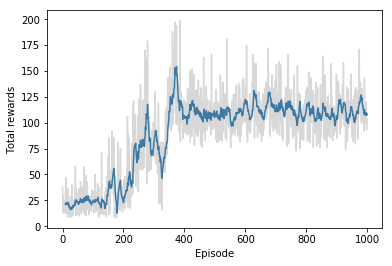

In [49]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

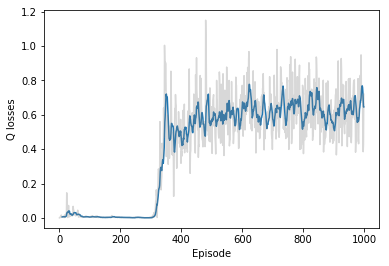

In [50]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, _, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [28]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.